In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import skew
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import lightgbm as lgb
from sklearn.ensemble import BaggingClassifier
from fancyimpute import IterativeImputer as FancyIterativeImputer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import optuna

import warnings

# Suppress only specific warning category
warnings.filterwarnings('ignore', category=UserWarning)

palette = ['#A87676', '#CA8787', '#E1ACAC', '#FFD0D0', '#DBA979', '#ECCA9C', '#E8EFCF']

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train_features.csv')
test = pd.read_csv('test_features.csv')
label = pd.read_csv('train_labels.csv')

test.drop('ID', axis=1, inplace=True)

# 1. **Exploratory Data Analysis** <a class="anchor" id="2"></a>

In [3]:
def get_missing_and_dtype(df):
    missing_values = df.isnull().sum()
    data_types = df.dtypes
    missing_percentage = round((missing_values / len(df)) * 100, 2)
    return missing_values,missing_percentage, data_types

train_missing_values, train_missing_percentage, train_data_types = get_missing_and_dtype(train)
test_missing_values, test_missing_percentage, test_data_types = get_missing_and_dtype(test)

combined_info = pd.DataFrame({
    'train_missing_values': train_missing_values,
    'train_missing_percentage':train_missing_percentage,
    'train_data_types': train_data_types,
    'test_missing_values': test_missing_values,
    'test_missing_percentage':test_missing_percentage,
    'test_data_types': test_data_types
})

combined_info.reset_index(inplace=True)
combined_info.rename(columns={'index': 'feature'}, inplace=True)
combined_info

,feature,train_missing_values,train_missing_percentage,train_data_types,test_missing_values,test_missing_percentage,test_data_types
0,tahun_kelahiran,0,0.00,int64,0,0.00,int64
1,pendidikan,189,4.95,object,204,5.34,object
2,status_pernikahan,212,5.55,object,182,4.77,object
3,pendapatan,190,4.98,float64,203,5.32,float64
4,jumlah_anak_balita,190,4.98,float64,209,5.47,float64
5,jumlah_anak_remaja,204,5.34,float64,210,5.50,float64
6,terakhir_belanja,172,4.51,float64,201,5.26,float64
7,belanja_buah,181,4.74,float64,186,4.87,float64
8,belanja_daging,178,4.66,float64,195,5.11,float64
9,belanja_ikan,193,5.06,float64,196,5.13,float64


* Note: data train tidak mempunyai feature ID, kita juga mempunyai beberapa missing values disini

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
tahun_kelahiran,3817.0,1.967824e+03,1.176813e+01,1899.0,1959.0,1968.0,1976.0,2000.0
pendapatan,3627.0,1.144832e+08,4.346042e+07,5073000.0,81125122.0,115621394.0,150495956.0,332884000.0
jumlah_anak_balita,3627.0,2.930797e-01,4.730627e-01,0.0,0.0,0.0,1.0,2.0
jumlah_anak_remaja,3613.0,3.537227e-01,4.930139e-01,0.0,0.0,0.0,1.0,2.0
terakhir_belanja,3645.0,4.723155e+01,2.706851e+01,0.0,25.0,47.0,69.0,128.0
belanja_buah,3636.0,5.980424e+04,7.402498e+04,0.0,7907.0,26456.0,86162.0,396508.0
belanja_daging,3639.0,4.385748e+05,5.120427e+05,0.0,49479.5,221993.0,686355.5,3489675.0
belanja_ikan,3624.0,8.142900e+04,9.997623e+04,0.0,10115.0,36054.5,121380.0,621600.0
belanja_kue,3603.0,6.337797e+04,7.943546e+04,0.0,7947.0,27795.0,89502.5,542164.0
pembelian_diskon,3639.0,2.125584e+00,2.100133e+00,0.0,0.0,2.0,3.0,20.0


In [5]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
tahun_kelahiran,3818.0,1.967790e+03,1.180857e+01,1892.0,1959.0,1968.0,1.976000e+03,2.009000e+03
pendapatan,3615.0,1.163249e+08,5.105122e+07,2998899.0,81681624.0,117732079.0,1.506877e+08,1.305740e+09
jumlah_anak_balita,3609.0,2.829039e-01,4.650046e-01,0.0,0.0,0.0,1.000000e+00,2.000000e+00
jumlah_anak_remaja,3608.0,3.553215e-01,4.968651e-01,0.0,0.0,0.0,1.000000e+00,2.000000e+00
terakhir_belanja,3617.0,4.718137e+01,2.694029e+01,0.0,25.0,46.0,6.800000e+01,1.330000e+02
belanja_buah,3632.0,6.123408e+04,7.664759e+04,0.0,7497.5,29525.0,8.677675e+04,4.086460e+05
belanja_daging,3623.0,4.528484e+05,5.123206e+05,0.0,54621.0,232753.0,7.217960e+05,3.271191e+06
belanja_ikan,3622.0,8.533861e+04,1.037895e+05,0.0,10115.0,40025.5,1.296568e+05,5.749320e+05
belanja_kue,3631.0,6.380151e+04,7.842854e+04,0.0,8092.0,29251.0,9.140700e+04,5.320490e+05
pembelian_diskon,3639.0,2.101676e+00,2.115571e+00,0.0,0.0,2.0,3.000000e+00,1.700000e+01


## 1.1 **EDA for Understanding the Data** <a class="anchor" id="1.1"></a>

### 1.1.1 **Analisis Missing Values** <a class="anchor" id="1.1"></a>


In [6]:
combined = pd.concat([train,label], axis=1)
test_df = test.copy()
combined.drop('tanggal_menjadi_anggota', axis=1, inplace=True)
test_df.drop('tanggal_menjadi_anggota', axis=1, inplace=True)

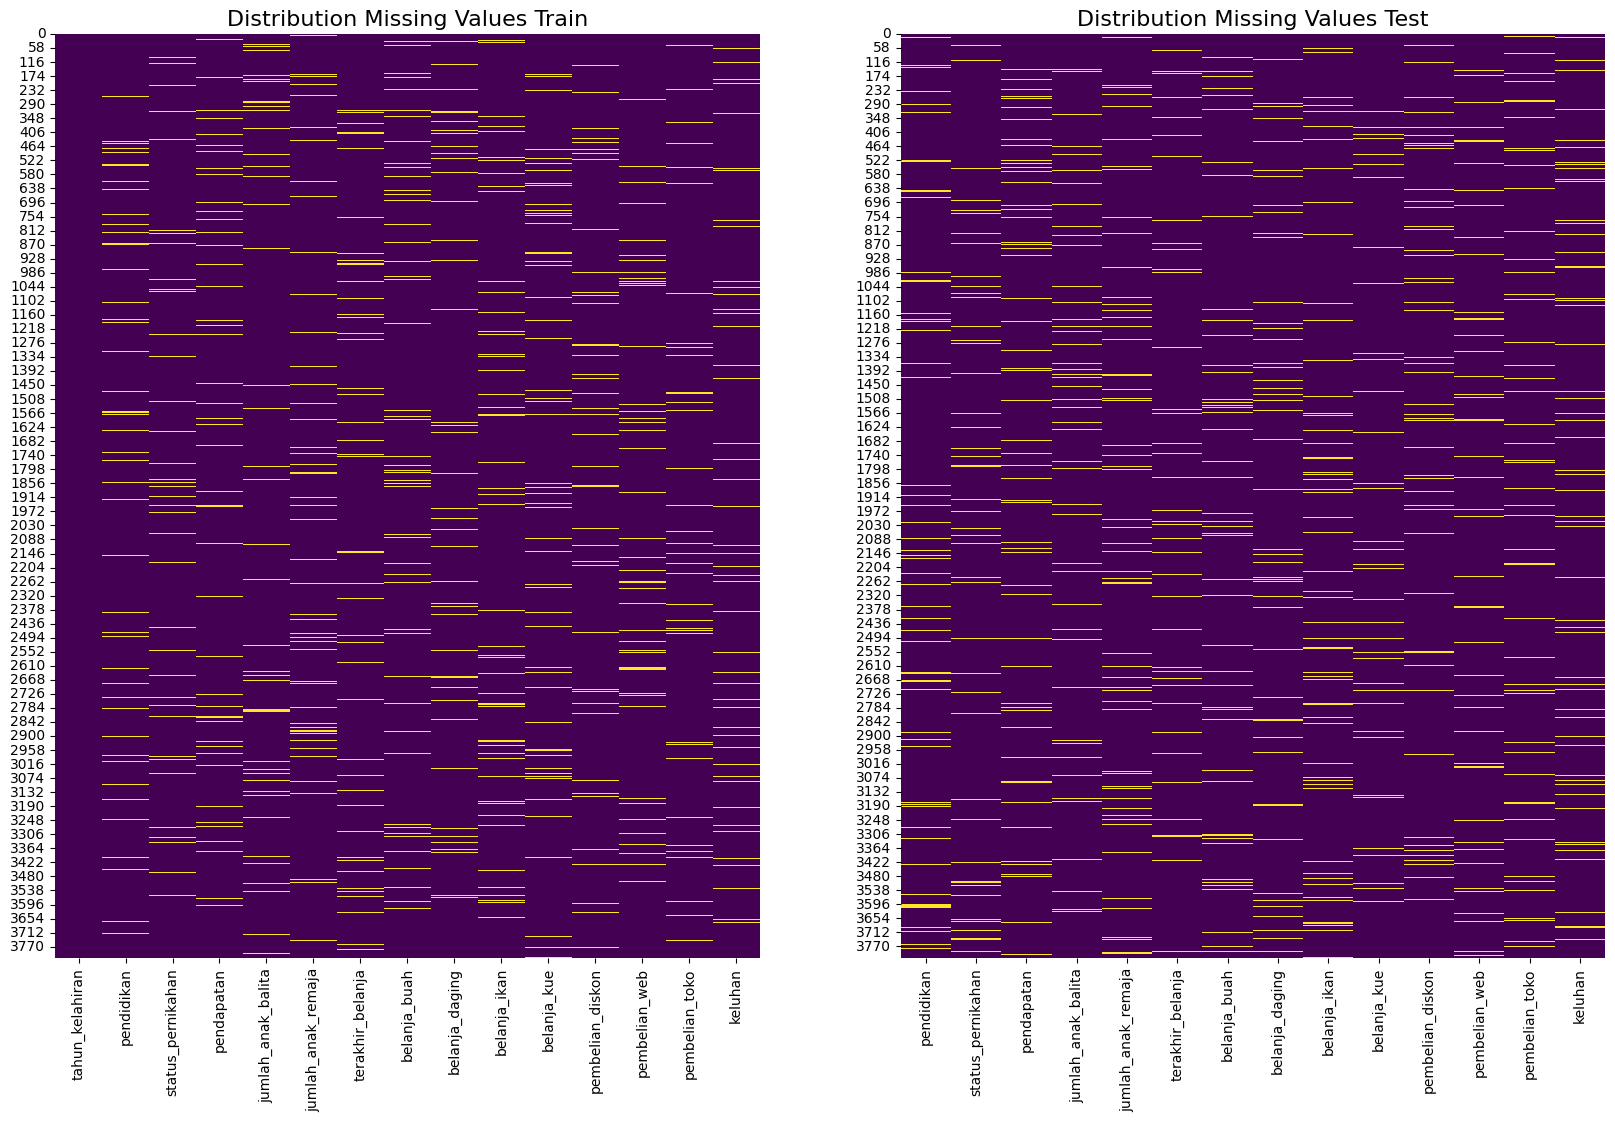

In [7]:
null_df = combined.isnull()
null_df = null_df.iloc[:,:-1]

test_c = test_df.copy()
null_df_test = test_c.isnull()
null_df_test = null_df_test.iloc[:,1:]


f, ax = plt.subplots(1, 2, figsize=(20,12))
sns.heatmap(null_df, cmap='viridis', cbar=False, ax=ax[0])
sns.heatmap(null_df_test, cmap='viridis', cbar=False, ax=ax[1])
ax[0].set_title('Distribution Missing Values Train', size=16)
ax[1].set_title('Distribution Missing Values Test', size=16)
plt.show()

In [8]:
cat = [cat for cat in combined.columns if combined[cat].dtype == 'object']
cat_df = combined[cat].isnull().sum().reset_index(name='count').sort_values('count',ascending=False)
cat_df_test = test_df[cat].isnull().sum().reset_index(name='count').sort_values('count',ascending=False)

num = [num for num in combined.columns if combined[num].dtype != 'object'][1:-1]
num_df = combined[num].isnull().sum().reset_index(name='count').sort_values('count',ascending=False)
num_df_test = test_df[num].isnull().sum().reset_index(name='count').sort_values('count',ascending=False)

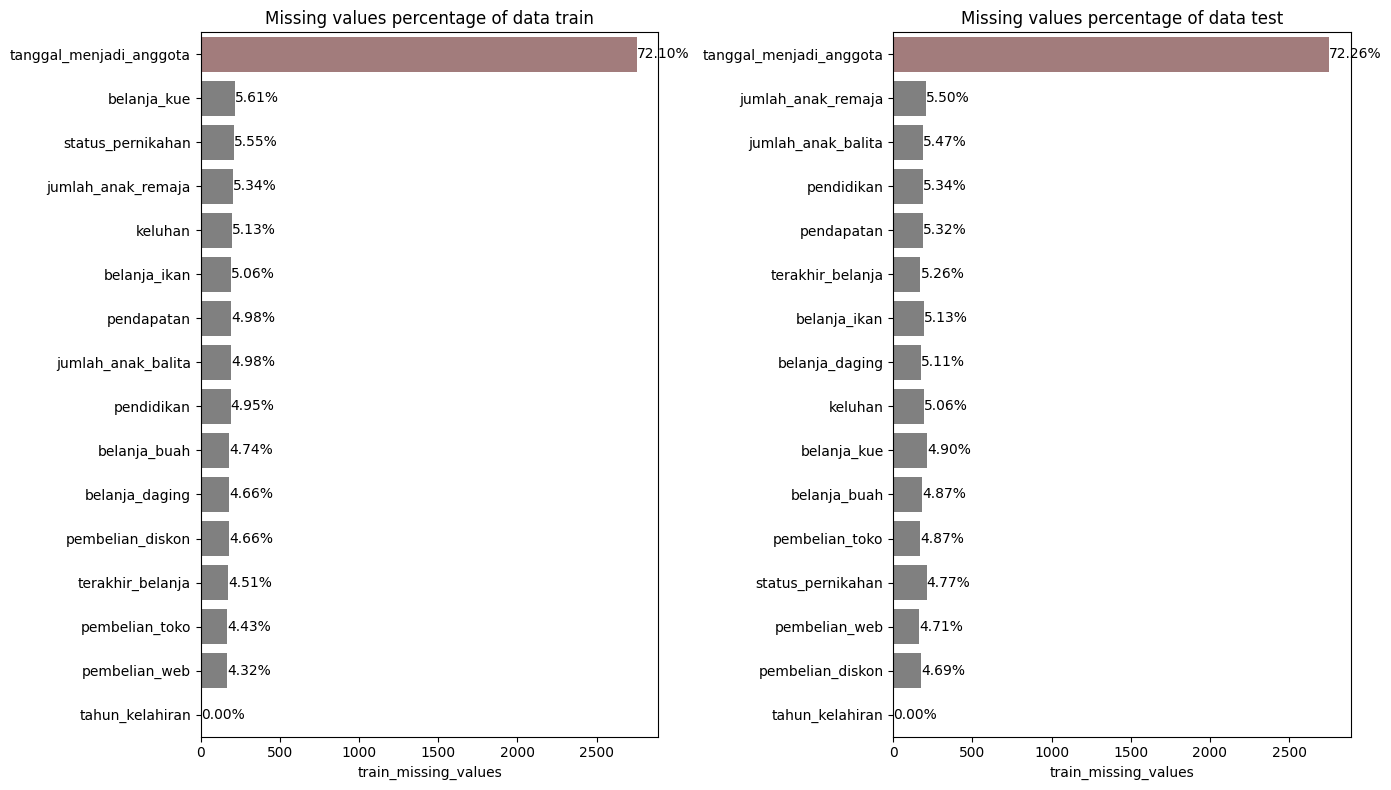

In [9]:
f, ax = plt.subplots(1,2, figsize=(14,8))
sorted_train = combined_info.sort_values('train_missing_values', ascending=False)
sorted_test = combined_info.sort_values('test_missing_values', ascending=False)

colors = ['#A87676'] + ['gray'] * (len(sorted_train['train_missing_values']) - 2) + ['lightsalmon']

sns.barplot(x=sorted_train['train_missing_values'], y=sorted_train['feature'], ax=ax[0], palette=colors)
sns.barplot(x=sorted_test['train_missing_values'], y=sorted_test['feature'], ax=ax[1], palette=colors)

ax[0].set_title('Missing values percentage of data train')
ax[1].set_title('Missing values percentage of data test')
ax[0].set_ylabel('')
ax[1].set_ylabel('')

for i, (value, percent) in enumerate(zip(sorted_train['train_missing_values'], sorted_train['train_missing_percentage'])):
    ax[0].text(value, i, f'{percent:.2f}%', ha='left', va='center')
    
for i, (value, percent) in enumerate(zip(sorted_test['train_missing_values'], sorted_test['test_missing_percentage'])):
    ax[1].text(value, i, f'{percent:.2f}%', ha='left', va='center')

plt.tight_layout()
plt.show()

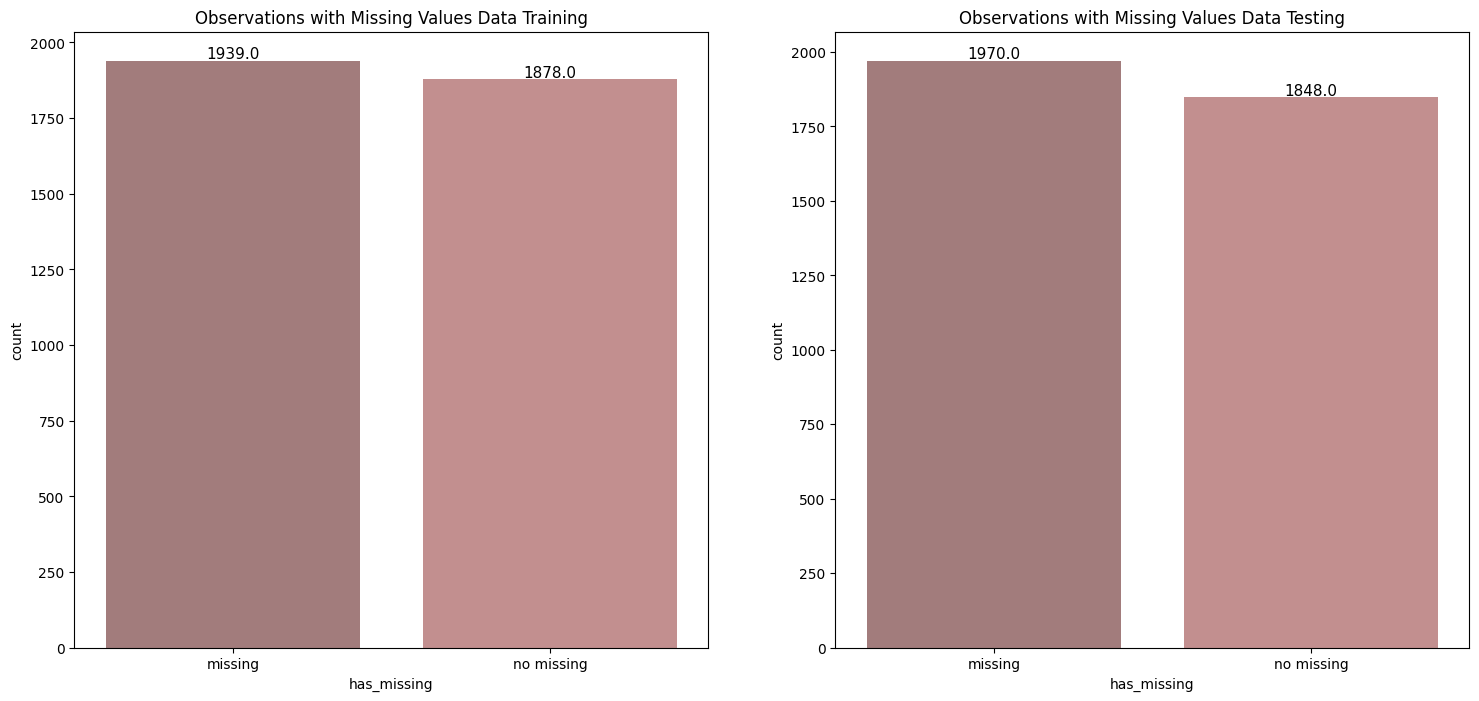

In [10]:
combined['has_missing'] = np.where(combined.isnull().any(axis=1), 'missing', 'no missing')
test_df['has_missing'] = np.where(test_df.isnull().any(axis=1), 'missing', 'no missing')

f, ax = plt.subplots(1,2,figsize=(18,8))
sns.countplot(x='has_missing', data=combined, palette=palette, ax=ax[0])
sns.countplot(x='has_missing', data=test_df, palette=palette, ax=ax[1])

for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                   textcoords='offset points')

# Annotate count values for the second subplot
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                   textcoords='offset points')
    
ax[0].set_title('Observations with Missing Values Data Training', size=12)
ax[1].set_title('Observations with Missing Values Data Testing', size=12)

plt.show()

In [11]:
# MCAR test 
df_binned = combined.apply(lambda x: pd.qcut(x.rank(method='first'), 3, labels=False) if x.dtype == 'float' else x)

for column in df_binned.columns:
    contingency_table = pd.crosstab(index=df_binned['has_missing'], columns=df_binned[column])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Feature: {column}, p-value: {p}")

Feature: tahun_kelahiran, p-value: 0.8135315484600257
Feature: pendidikan, p-value: 0.04630839086761121
Feature: status_pernikahan, p-value: 0.7882891836685941
Feature: pendapatan, p-value: 0.09177054641084598
Feature: jumlah_anak_balita, p-value: 0.09086303575133099
Feature: jumlah_anak_remaja, p-value: 0.3681643494769199
Feature: terakhir_belanja, p-value: 0.2284892404484227
Feature: belanja_buah, p-value: 0.6529812875046881
Feature: belanja_daging, p-value: 0.3714628273981751
Feature: belanja_ikan, p-value: 0.678458554011683
Feature: belanja_kue, p-value: 0.43861470892184595
Feature: pembelian_diskon, p-value: 0.8176161410520967
Feature: pembelian_web, p-value: 0.9577783291069633
Feature: pembelian_toko, p-value: 0.4862527656911144
Feature: keluhan, p-value: 0.35039920899281873
Feature: jumlah_promosi, p-value: 0.12515643502816742
Feature: has_missing, p-value: 0.0


In [12]:
# MCAR test 
df_binned = test_df.apply(lambda x: pd.qcut(x.rank(method='first'), 3, labels=False) if x.dtype == 'float' else x)

for column in df_binned.columns:
    contingency_table = pd.crosstab(index=df_binned['has_missing'], columns=df_binned[column])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Feature: {column}, p-value: {p}")

Feature: tahun_kelahiran, p-value: 0.9256592435092567
Feature: pendidikan, p-value: 0.5252209735978515
Feature: status_pernikahan, p-value: 0.39280692906633635
Feature: pendapatan, p-value: 0.09121251146470233
Feature: jumlah_anak_balita, p-value: 0.32697989611432104
Feature: jumlah_anak_remaja, p-value: 0.6473792192012442
Feature: terakhir_belanja, p-value: 0.23846390541537707
Feature: belanja_buah, p-value: 0.0972860688508876
Feature: belanja_daging, p-value: 0.26093475174469266
Feature: belanja_ikan, p-value: 0.9418652040681017
Feature: belanja_kue, p-value: 0.9038299019703327
Feature: pembelian_diskon, p-value: 0.6219023053597779
Feature: pembelian_web, p-value: 0.13654833653840867
Feature: pembelian_toko, p-value: 0.0885946182179587
Feature: keluhan, p-value: 0.9801070467169216
Feature: has_missing, p-value: 0.0


### 1.1.2 **Analisis Label Distribution** <a class="anchor" id="1.1"></a>

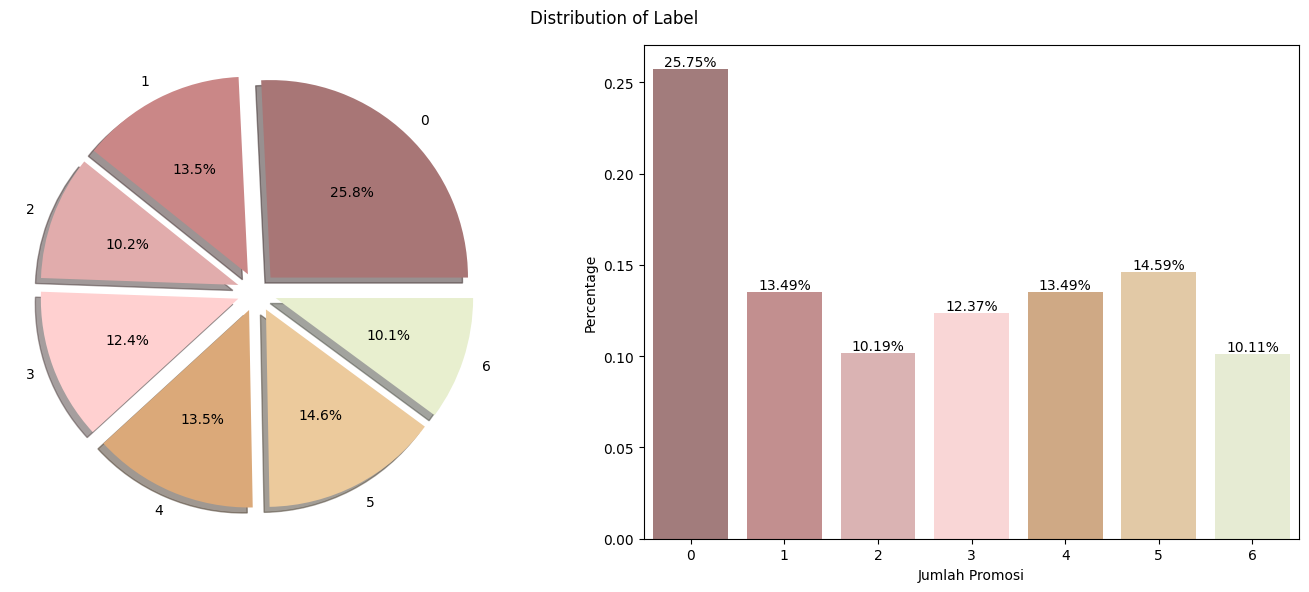

In [13]:
label_check = label.value_counts(normalize=True).reset_index()
label_check = label_check.sort_values('jumlah_promosi',ascending=True)

category_counts = label_check['proportion']
feature_names = label_check['jumlah_promosi']

f, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].pie(category_counts, 
          labels=feature_names, 
          autopct='%1.1f%%', 
          shadow=True,
          colors=palette,
          explode=[0.1]*len(feature_names))  


sns.barplot(x=label_check['jumlah_promosi'], y=label_check['proportion'], palette=palette, ax=ax[1])

for i, proportion in enumerate(label_check['proportion']):
    ax[1].text(i, proportion, f"{proportion*100:.2f}%", ha='center', va='bottom')

ax[1].set_xlabel('Jumlah Promosi')
ax[1].set_ylabel('Percentage')

f.suptitle('Distribution of Label', fontsize=12)

plt.tight_layout()
plt.show()

### 1.1.3 **Analisis Distribution Categorical Features** <a class="anchor" id="1.1"></a>

- Data Training

In [14]:
mask = combined['pendidikan'].value_counts().reset_index(name='count').sort_values('count', ascending=False)

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['pendidikan'],
        title="Data Train",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
    marker=dict(
        colors=palette,
        line=dict(color='#000000',
                  width=2)
        )
    )
fig.layout.update(title="<b>Distribution of pendidikan<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()


In [15]:
mask = combined['status_pernikahan'].value_counts().reset_index(name='count').sort_values('count', ascending=False)

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['status_pernikahan'],
        title="Data Train",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
     marker=dict(
        colors=palette,
        line=dict(color='#000000',
                  width=2)
        )
    )
fig.layout.update(title="<b>Distribution of Status Pernikahan<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()

- Data test

In [16]:
mask = test_df['pendidikan'].value_counts().reset_index(name='count').sort_values('count', ascending=False)

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['pendidikan'],
        title="Data Test",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
    marker=dict(
        colors=palette,
        line=dict(color='#000000',
                  width=2)
        )
    )
fig.layout.update(title="<b>Distribution of pendidikan<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()

In [17]:
mask = test_df['status_pernikahan'].value_counts().reset_index(name='count').sort_values('count', ascending=False)
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['status_pernikahan'],
        title="Data Test",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
    marker=dict(
        colors=palette,
        line=dict(color='#000000',
                  width=2)
        )
    )
fig.layout.update(title="<b>Distribution of Status Pernikahan<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()

### 1.1.4 **Analisis Distribution Pairs** <a class="anchor" id="1.1"></a>

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\s

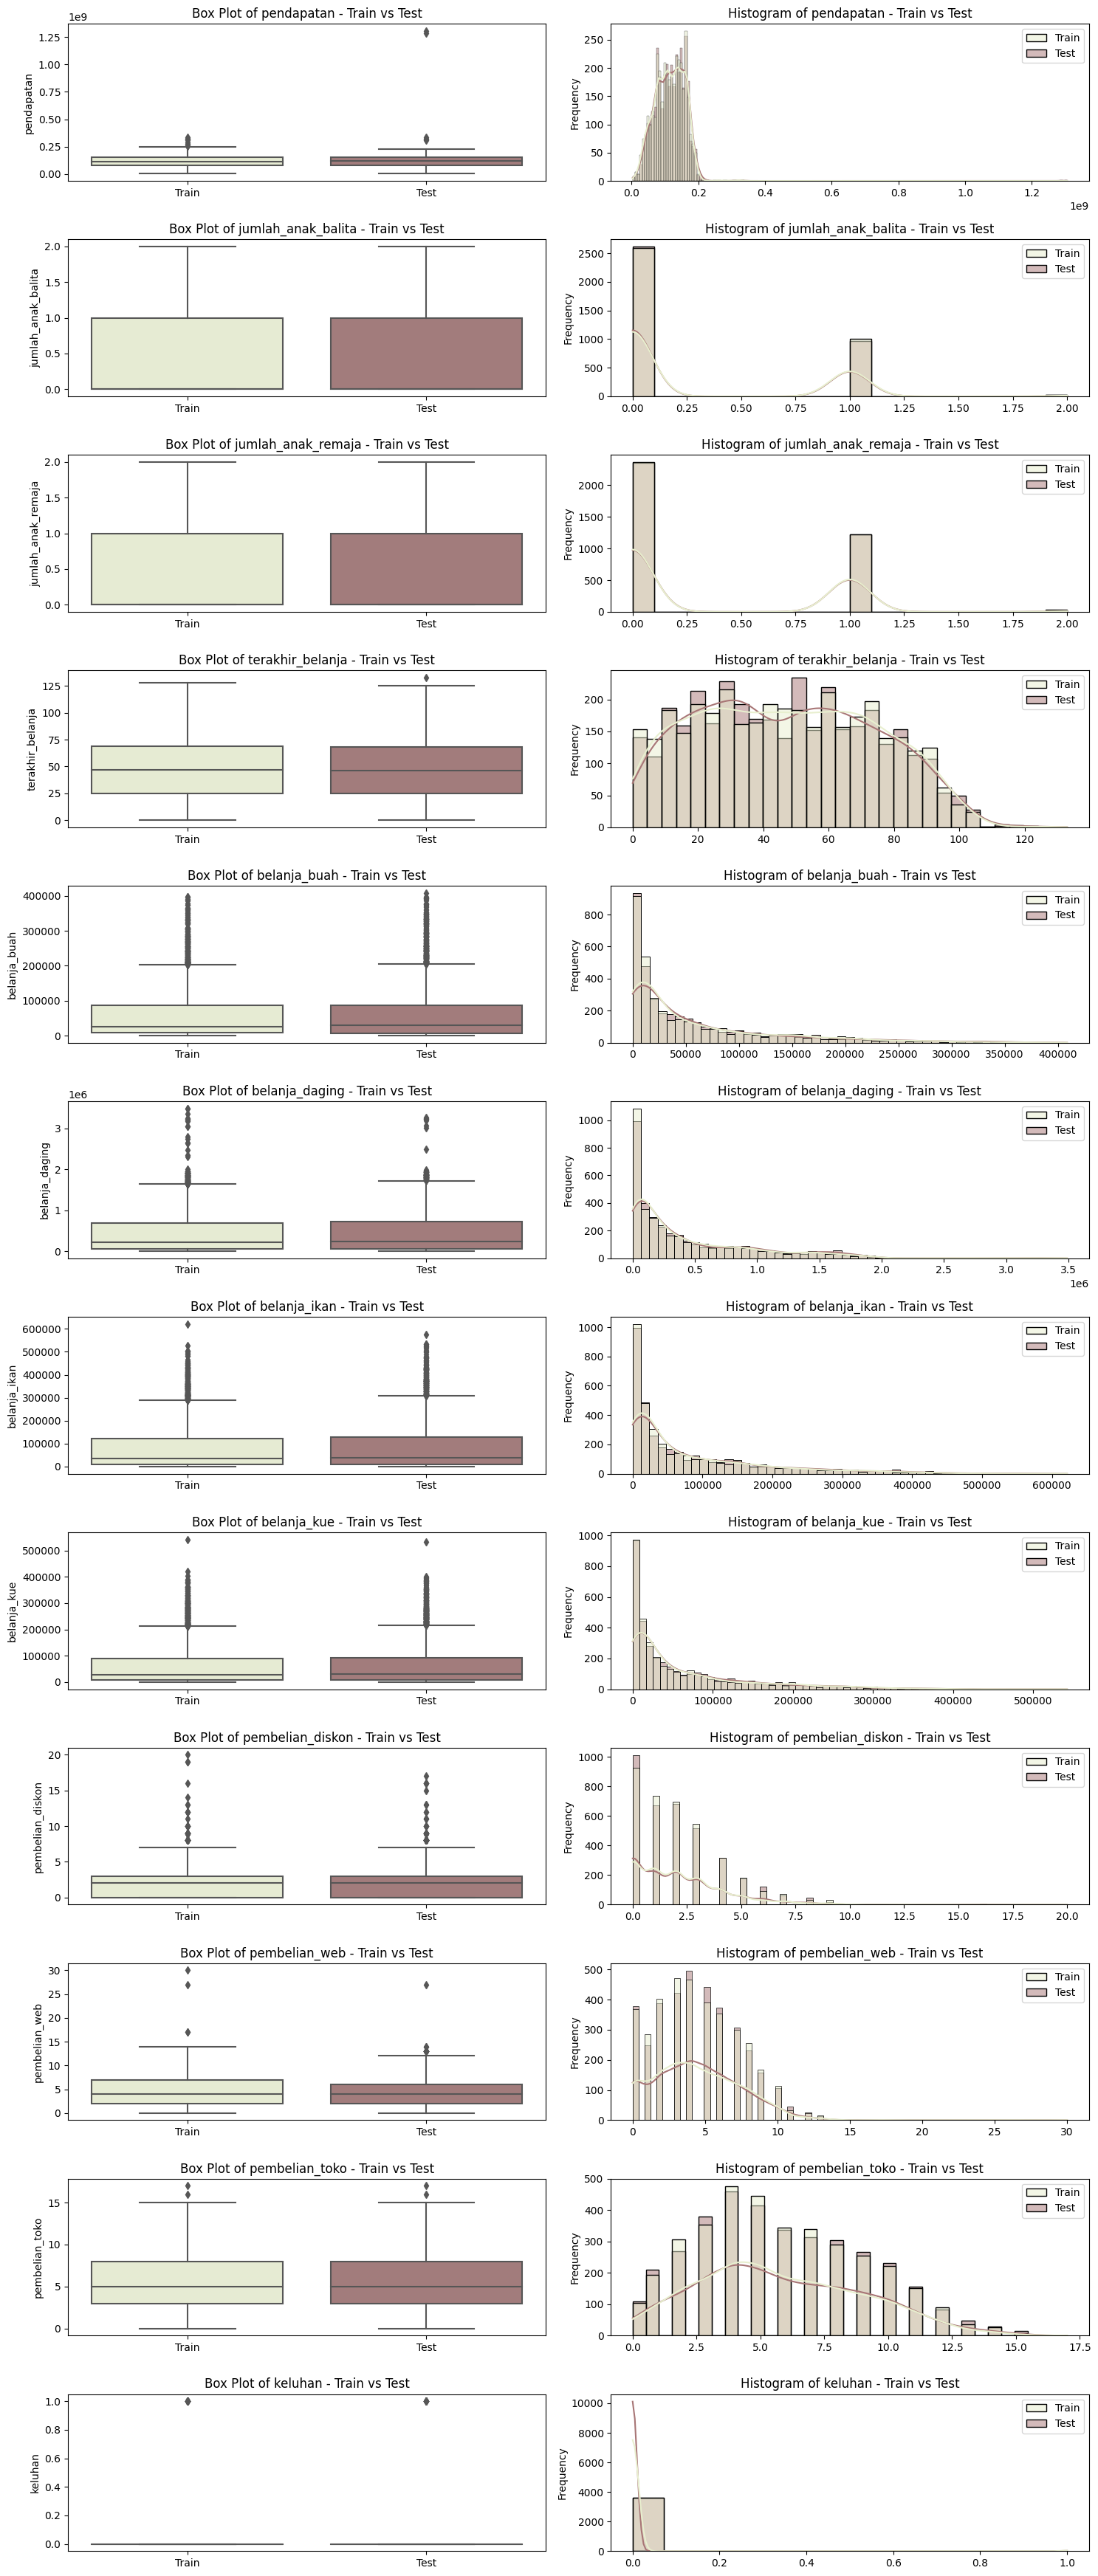

In [18]:
f, ax = plt.subplots(len(num), 2, figsize=(15, 35))
colors = ['#E8EFCF', '#A87676']

combined.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

for i, col in enumerate(num):
    # Boxplot for Train vs Test
    sns.boxplot(x='dataset', y=col, data=pd.concat([combined.assign(dataset='Train'), test_df.assign(dataset='Test')]), ax=ax[i, 0], palette=colors)
    ax[i, 0].set_title(f'Box Plot of {col} - Train vs Test')
    ax[i, 0].set_xlabel('')
    ax[i, 0].set_ylabel(col)
    
    # Histogram for Train vs Test
    sns.histplot(data=pd.concat([combined[col], test_df[col]], axis=1, keys=['Train', 'Test']), ax=ax[i, 1], kde=True, fill=True, palette=colors)
    ax[i, 1].set_title(f'Histogram of {col} - Train vs Test')
    ax[i, 1].set_xlabel('')
    ax[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.1.5 **Adversarial Validation** <a class="anchor" id="1.1"></a>

In [19]:
imputer = SimpleImputer(strategy='median')
train_filled = combined[num].copy()  
train_filled[num] = imputer.fit_transform(train_filled[num])
train_filled = pd.DataFrame(train_filled, columns=train[num].columns)
test_filled = test_df[num].copy()  
test_filled[num] = imputer.transform(test_filled[num]) 
test_filled = pd.DataFrame(test_filled, columns=test[num].columns)

X =  pd.concat([train_filled[num], test_filled[num]], axis=0)
y = [0] * len(train_filled) + [1] * len(test_filled)

model = RandomForestClassifier(random_state=0)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.506


### 1.1.6 **Mutual Information Analysis** <a class="anchor" id="1.1"></a>

In [20]:
train_filled['pendidikan'] = train['pendidikan']
train_filled['pendidikan']  = train_filled['pendidikan'].fillna(train_filled['pendidikan'].mode()[0])
train_filled['status_pernikahan'] = train['status_pernikahan']
train_filled['status_pernikahan']  = train_filled['status_pernikahan'].fillna(train_filled['status_pernikahan'].mode()[0])

encoder = LabelEncoder()
train_filled['pendidikan'] = encoder.fit_transform(train_filled['pendidikan'])
train_filled['status_pernikahan'] = encoder.fit_transform(train_filled['status_pernikahan'])


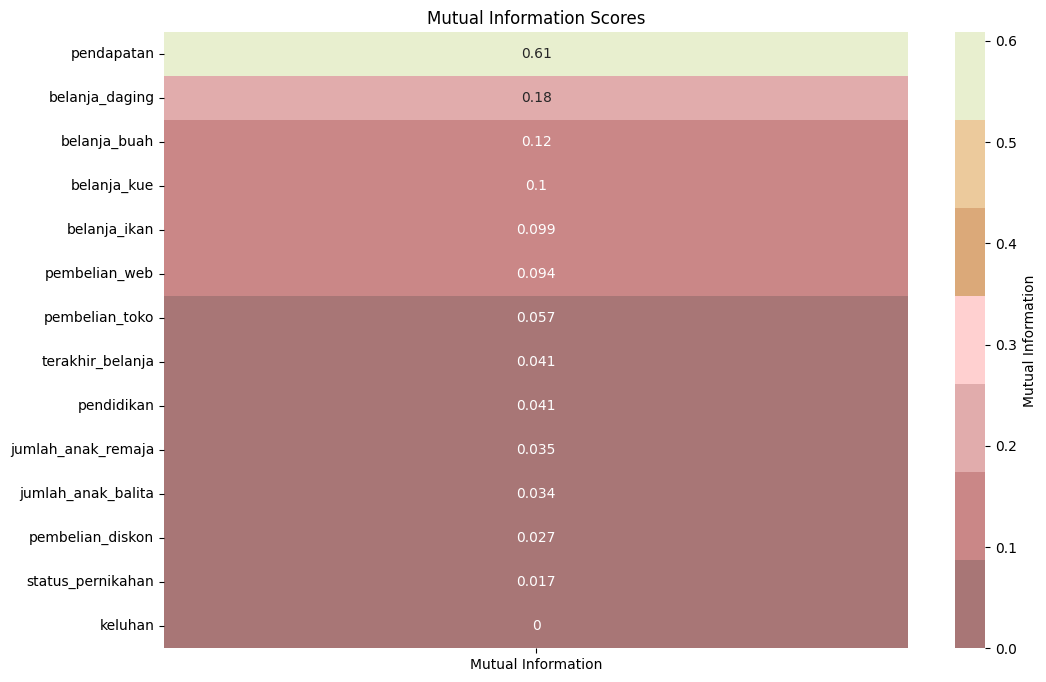

In [21]:
mi = mutual_info_classif(train_filled, label, discrete_features='auto')

mi_matrix = pd.DataFrame(mi, index=train_filled.columns, columns=['Mutual Information'])
mi_matrix.sort_values('Mutual Information', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(mi_matrix, annot=True, cmap=palette, cbar_kws={'label': 'Mutual Information'})
plt.title('Mutual Information Scores')
plt.show()

# 2. **Preprocessing Data** <a class="anchor" id="2"></a>

- Imputation data numeric

In [22]:
num_cols = [col for col in train.columns if train[col].dtype != 'object']
test_num_cols = [col for col in test.columns if test[col].dtype != 'object']

train_num = train[num_cols].copy()
test_num = test[test_num_cols].copy()

In [23]:
params = {'learning_rate': 0.007353634265704398, 
          'verbosity':-1,
          'lambda_l1': 3.664181138122969e-05, 
          'lambda_l2': 0.397498474634019,
          'max_depth': 15, 
          'colsample_bytree': 0.6671155956864336, 
          'subsample': 0.6455796395952734, 
          'seed':0,
          'n_estimators':3000,
          'min_child_weight': 1, 
          'num_leaves': 998, 
          'min_child_samples': 11}

def rmse(y1,y2):
    ''' RMSE Evaluator'''
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))

def store_missing_rows(df, features):
    '''Function untuk penyimpanan nilai nan pada suatu features'''
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows

def fill_missing_numerical(train,test,target, max_iterations=10):
    train_temp=train.copy()
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    
    features=[ f for f in df.columns if df[f].isna().sum()>0]
    if len(features)>0:
        # Step 1: Simpan instance dengan nilai yang hilang di setiap feature
        missing_rows = store_missing_rows(df, features)
        # Step 2: Awalnya isi semua nilai yang hilang dengan "Hilang"
        for f in features:
            df[f]=df[f].fillna(df[f].median())
        
        dictionary = {feature: [] for feature in features}

        for iteration in tqdm(range(max_iterations), desc="Iterations"):
            for feature in features:
                # Skip features yang tidak mempunyai Nan
                rows_miss = missing_rows[feature].index

                missing_temp = df.loc[rows_miss].copy()
                non_missing_temp = df.drop(index=rows_miss).copy()
                y_pred_prev=missing_temp[feature]
                missing_temp = missing_temp.drop(columns=[feature])
                
                # Step 3: Gunakan fitur lainnya untuk memprediksi nilai yang hilang menggunakan LGBMRegressor
                X_train = non_missing_temp.drop(columns=[feature])
                y_train = non_missing_temp[[feature]]

                model= lgb.LGBMRegressor(**params)
                model.fit(X_train, y_train)
                
                # Step 4: Prediksi nilai yang hilang untuk fitur tersebut dan perbarui semua Nan feature
                y_pred = model.predict(missing_temp)
                df.loc[rows_miss, feature] = y_pred
                error_minimize=rmse(y_pred,y_pred_prev)
                dictionary[feature].append(error_minimize)  

        for feature, values in dictionary.items():
             iterations = range(1, len(values) + 1)  # x-axis values (iterations)
             plt.plot(iterations, values, label=feature)  # plot the values
             plt.xlabel('Iterations')
             plt.ylabel('RMSE')
             plt.title('Minimization of RMSE with iterations')
             plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        train[features] = np.array(df.iloc[:train.shape[0]][features])
        test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test

Iterations: 100%|██████████| 10/10 [19:59<00:00, 120.00s/it]


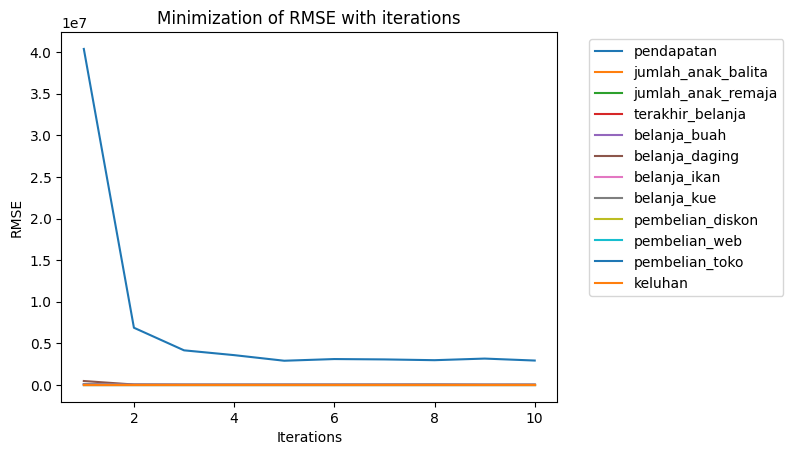

In [24]:
#proses ini akan memakan waktu sekitar 60mnt
train_copy,test_copy = fill_missing_numerical(train_num,test_num,label)

In [25]:
train_copy = round(train_copy)
test_copy = round(test_copy)

In [26]:
train.loc[train['status_pernikahan'] == '5', 'status_pernikahan'] = np.nan
train.loc[train['pendidikan'] == '5', 'pendidikan'] = np.nan

test.loc[test['status_pernikahan'] == '5', 'status_pernikahan'] = np.nan
test.loc[test['pendidikan'] == '5', 'pendidikan'] = np.nan

train_copy['pendidikan'] = train['pendidikan']
train_copy['status_pernikahan'] = train['status_pernikahan']

test_copy['pendidikan'] = test['pendidikan']
test_copy['status_pernikahan'] = test['status_pernikahan']

- Imputation data categorical

In [27]:
def imputation_cat(df, features, key=''):
    x = df.copy()
    if key == 'pendidikan':
        x['status_pernikahan'] = x['status_pernikahan'].fillna(x['status_pernikahan'].mode()[0])
        encoder = LabelEncoder()
        x['status_pernikahan'] = encoder.fit_transform(x['status_pernikahan'])
    
    features_cluster = x[features]
    num_cluster = 4
    kmeans = KMeans(init='k-means++', n_clusters=num_cluster, random_state=42)
    df['Cluster'] = kmeans.fit_predict(features_cluster)
    cluster_mapping = df.groupby('Cluster')[key].agg(lambda col: col.value_counts().idxmax()).to_dict()
    df[key] = df.apply(lambda row: cluster_mapping.get(row['Cluster']) if pd.isnull(row[key]) else row[key], axis=1)
    df = df.drop('Cluster', axis=1)
    return df

features_pendidikan = ['pendapatan', 'status_pernikahan', 'jumlah_anak_balita', 'jumlah_anak_remaja']
features_status_pernikahan = ['pendapatan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'terakhir_belanja', 'pembelian_toko']

train_copy = imputation_cat(train_copy, features_pendidikan, 'pendidikan')
train_copy = imputation_cat(train_copy, features_status_pernikahan, 'status_pernikahan')

test_copy = imputation_cat(test_copy, features_pendidikan, 'pendidikan')
test_copy = imputation_cat(test_copy, features_status_pernikahan, 'status_pernikahan')

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



- Encoding Categorical 

In [28]:
label_encoder = LabelEncoder()
train_copy['status_pernikahan'] = label_encoder.fit_transform(train_copy['status_pernikahan'])
train_copy['pendidikan'] = label_encoder.fit_transform(train_copy['pendidikan'])

In [29]:
label_encoder = LabelEncoder()
test_copy['status_pernikahan'] = label_encoder.fit_transform(test_copy['status_pernikahan'])
test_copy['pendidikan'] = label_encoder.fit_transform(test_copy['pendidikan'])

# 3. **Feature Engineering** <a class="anchor" id="2"></a>

Pada bagian ini akan dibuat 8 new features untuk data train maupun data training 

- Data Train

In [30]:
train_copy['pembelian_interaction'] = train_copy['pembelian_diskon'] * (train_copy['pembelian_web'] + train_copy['pembelian_toko'])
train_copy['promotion_frequency'] = train_copy[['pembelian_diskon', 'pembelian_web', 'pembelian_toko']].sum(axis=1) / train_copy[['belanja_buah', 'belanja_daging', 
                                                                                                                                  'belanja_ikan', 'belanja_kue']].sum(axis=1)
train_copy['income_family_ratio'] = train_copy['pendapatan'] / (train_copy['jumlah_anak_balita'] + train_copy['jumlah_anak_remaja'] + 1)

train_copy['sum_spending'] = train_copy['belanja_buah'] + train_copy['belanja_daging'] + train_copy['belanja_ikan'] + train_copy['belanja_kue']

purchase_columns = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
train_copy['purchase_diversity'] = train_copy[purchase_columns].apply(lambda x: -np.sum(x / x.sum() * np.log(x / x.sum())), axis=1)

train_copy['promotion_interaction_ratio'] = train_copy['pembelian_interaction'] / train_copy['sum_spending']
train_copy['promotion_sensitivity'] = train_copy['pembelian_diskon'] / train_copy['sum_spending']

shopping_columns = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
train_copy['total_spending_diversity'] = train_copy[shopping_columns].sum(axis=1)

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

invalid value encountered in log



- Data Test

In [31]:
test_copy['pembelian_interaction'] = test_copy['pembelian_diskon'] * (test_copy['pembelian_web'] + test_copy['pembelian_toko'])
test_copy['promotion_frequency'] = test_copy[['pembelian_diskon', 'pembelian_web', 'pembelian_toko']].sum(axis=1) / test_copy[['belanja_buah', 'belanja_daging', 
                                                                                                                               'belanja_ikan', 'belanja_kue']].sum(axis=1)
test_copy['income_family_ratio'] = test_copy['pendapatan'] / (test_copy['jumlah_anak_balita'] + test_copy['jumlah_anak_remaja'] + 1)

test_copy['sum_spending'] = test_copy['belanja_buah'] + test_copy['belanja_daging'] + test_copy['belanja_ikan'] + test_copy['belanja_kue']

purchase_columns = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
test_copy['purchase_diversity'] = test_copy[purchase_columns].apply(lambda x: -np.sum(x / x.sum() * np.log(x / x.sum())), axis=1)
test_copy['promotion_sensitivity'] = test_copy['pembelian_diskon'] / test_copy['sum_spending']
test_copy['promotion_interaction_ratio'] = test_copy['pembelian_interaction'] / test_copy['sum_spending']
shopping_columns = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
test_copy['total_spending_diversity'] = test_copy[shopping_columns].sum(axis=1)

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log

c:\Users\USER\Documents\anaconda\envs\tensor\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

invalid value encountered in log



In [32]:
num_cols = [col for col in train_copy.columns if train_copy[col].dtype != 'object'][1:]

infinite_counts = {}

for col in train_copy[num_cols].columns:
    infinite_count = np.sum(np.isinf(train_copy[col]))
    infinite_counts[col] = infinite_count

for col, count in infinite_counts.items():
    print(f"Column '{col}' contains {count} infinite values.")

Column 'pendapatan' contains 0 infinite values.
Column 'jumlah_anak_balita' contains 0 infinite values.
Column 'jumlah_anak_remaja' contains 0 infinite values.
Column 'terakhir_belanja' contains 0 infinite values.
Column 'belanja_buah' contains 0 infinite values.
Column 'belanja_daging' contains 0 infinite values.
Column 'belanja_ikan' contains 0 infinite values.
Column 'belanja_kue' contains 0 infinite values.
Column 'pembelian_diskon' contains 0 infinite values.
Column 'pembelian_web' contains 0 infinite values.
Column 'pembelian_toko' contains 0 infinite values.
Column 'keluhan' contains 0 infinite values.
Column 'pendidikan' contains 0 infinite values.
Column 'status_pernikahan' contains 0 infinite values.
Column 'pembelian_interaction' contains 0 infinite values.
Column 'promotion_frequency' contains 1 infinite values.
Column 'income_family_ratio' contains 0 infinite values.
Column 'sum_spending' contains 0 infinite values.
Column 'purchase_diversity' contains 0 infinite values.
C

In [33]:
num_cols = [col for col in test_copy.columns if test_copy[col].dtype != 'object'][1:]

infinite_counts = {}

for col in test_copy[num_cols].columns:
    infinite_count = np.sum(np.isinf(test_copy[col]))
    infinite_counts[col] = infinite_count

for col, count in infinite_counts.items():
    print(f"Column '{col}' contains {count} infinite values.")

Column 'pendapatan' contains 0 infinite values.
Column 'jumlah_anak_balita' contains 0 infinite values.
Column 'jumlah_anak_remaja' contains 0 infinite values.
Column 'terakhir_belanja' contains 0 infinite values.
Column 'belanja_buah' contains 0 infinite values.
Column 'belanja_daging' contains 0 infinite values.
Column 'belanja_ikan' contains 0 infinite values.
Column 'belanja_kue' contains 0 infinite values.
Column 'pembelian_diskon' contains 0 infinite values.
Column 'pembelian_web' contains 0 infinite values.
Column 'pembelian_toko' contains 0 infinite values.
Column 'keluhan' contains 0 infinite values.
Column 'pendidikan' contains 0 infinite values.
Column 'status_pernikahan' contains 0 infinite values.
Column 'pembelian_interaction' contains 0 infinite values.
Column 'promotion_frequency' contains 3 infinite values.
Column 'income_family_ratio' contains 0 infinite values.
Column 'sum_spending' contains 0 infinite values.
Column 'purchase_diversity' contains 0 infinite values.
C

In [34]:
#Data Train
inf_columns = train_copy[num_cols].columns.to_numpy()[np.isinf(train_copy[num_cols].to_numpy()).any(axis=0)]
column_medians = train_copy.median()

# Rmengganti inf values dengan median
for col in inf_columns:
    train_copy[col].replace([np.inf, -np.inf], column_medians[col], inplace=True)
    
#Data test
inf_columns = test_copy[num_cols].columns.to_numpy()[np.isinf(test_copy[num_cols].to_numpy()).any(axis=0)]
column_medians = test_copy.median()

for col in inf_columns:
    test_copy[col].replace([np.inf, -np.inf], column_medians[col], inplace=True)

In [35]:
med = test_copy['promotion_sensitivity'].median()
test_copy['promotion_sensitivity'] = test_copy['promotion_sensitivity'].fillna(med)

med2 = test_copy['promotion_interaction_ratio'].median()
test_copy['promotion_interaction_ratio'] = test_copy['promotion_interaction_ratio'].fillna(med2)

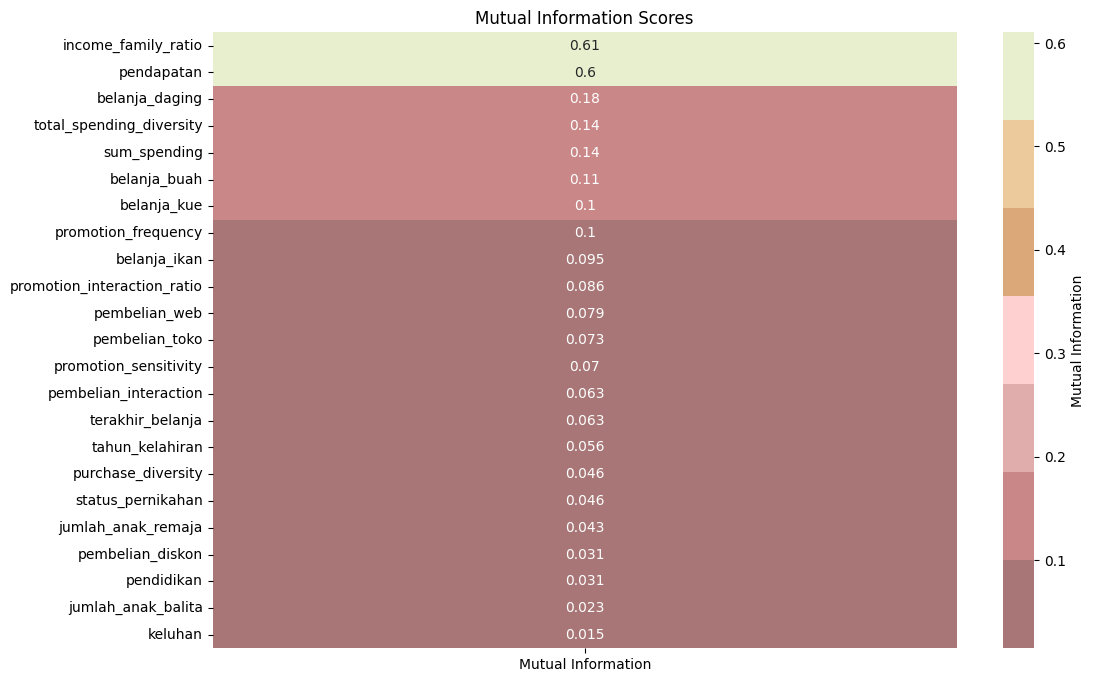

In [36]:
mi = mutual_info_classif(train_copy, label, discrete_features='auto')

mi_matrix = pd.DataFrame(mi, index=train_copy.columns, columns=['Mutual Information'])
mi_matrix.sort_values('Mutual Information', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(mi_matrix, annot=True, cmap=palette, cbar_kws={'label': 'Mutual Information'})
plt.title('Mutual Information Scores')
plt.show()

# 4. **Model Development** <a class="anchor" id="2"></a>

Model developmet yang dilakukan:
- Handling imbalance data menggunakan smote
- Melakukan hyperparamater tunning untuk setiap model kecuali random forest
- Stacking dengan total base model 8 dan meta model 1 (Random Forest)

In [37]:
X = train_copy.copy()
y = label
test = test_copy.copy()

X['income_family_ratio'] = round(X['income_family_ratio'])

In [38]:
X.drop(['keluhan','jumlah_anak_balita','jumlah_anak_remaja'], axis=1, inplace=True)
test.drop(['keluhan','jumlah_anak_balita','jumlah_anak_remaja'], axis=1, inplace=True)

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled_smot, y_train_resampled_smot= smote.fit_resample(X, label)

In [40]:
tune_model = False

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

- Tunning LGBM

In [41]:
def objective(trial):
    param = {
    'objective': 'multiclass',  
    'num_class': 7,  # Sesuai dengan output atau label nunique
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
    'n_estimators': 5000,
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
    'device_type': 'cpu',
    'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "verbosity": -1,
    "early_stopping_rounds": 50,
    }
    param['random_state'] = 40

    f1 = []

    for train_idx, valid_idx in cv.split(X_train_resampled_smot, y_train_resampled_smot):
        X_train_fold, X_valid_fold = X_train_resampled_smot.iloc[train_idx], X_train_resampled_smot.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_resampled_smot.iloc[train_idx], y_train_resampled_smot.iloc[valid_idx]
        
        # Create and fit the model
        model = LGBMClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])

        # Prediction pada data validasi dan data training
        y_preds = model.predict(X_valid_fold)
        train_preds = model.predict(X_train_fold)
        # mengevaluasi menggunakan metrics F1 Macro
        average_f1 = macro_f1(y_valid_fold, y_preds)
        #average_f1_train = macro_f1(y_xgb_train_fold, train_preds)
        #print(f'f1 macro val = {average_f1} | f1 macro train = {average_f1_train}')
        f1.append(average_f1)
    return np.mean(f1)

# Run Optuna optimization
if tune_model:
    lgbm_study = optuna.create_study(direction='maximize',study_name = "lgbm_model_training")
    lgbm_study.optimize(objective, n_trials=500) 

    # Output the optimization results
    print(f"Best trial average F1 MACRO: {lgbm_study.best_value:.4f}")
    print(lgbm_study.best_params)
    for key, value in lgbm_study.best_params.items():
        print(f"{key}: {value}")

- Tunning XGB

In [42]:
def objective(trial):
    param = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'multi_strategy': trial.suggest_categorical('multi_strategy', ["one_output_per_tree"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'gamma' : trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True), 
    }
    param['n_estimators'] = 5000
    param['early_stopping_rounds'] = 100
    param['booster'] = 'gbtree'
    param["verbosity"] = 0
    param['tree_method'] = "hist"
    param['random_state'] = 40
    
    f1 = []
    for train_idx, valid_idx in cv.split(X_train_resampled_smot, y_train_resampled_smot):
        X_train_fold, X_valid_fold = X_train_resampled_smot.iloc[train_idx], X_train_resampled_smot.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_resampled_smot.iloc[train_idx], y_train_resampled_smot.iloc[valid_idx]
                
        model = XGBClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)],verbose=False)

        y_preds = model.predict(X_valid_fold)
        train_preds = model.predict(X_train_fold)
        
        average_f1 = macro_f1(y_valid_fold, y_preds)
        #average_f1_train = macro_f1(y_train_fold, train_preds)
        #print(f'f1 macro val = {average_f1} | f1 macro train = {average_f1_train}')
        f1.append(average_f1)
    return np.mean(f1)


if tune_model:
    study = optuna.create_study(direction='maximize',study_name = "xgb_model_training")
    study.optimize(objective, n_trials=500)  
    
    print(f"Best trial average F1: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

- Tunning CATBoost

In [47]:
def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')
def objective(trial):
    param = {
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        'n_estimators': 2000,
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.001, 10.0, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "bootstrap_type": "Bernoulli",
        "early_stopping_rounds": 100,
        "task_type": 'CPU',
        "verbose": False,
        'random_state':42
    }

   
    f1 = []
    for train_idx, valid_idx in cv.split(X_train_resampled_smot, y_train_resampled_smot):
        X_train_fold, X_valid_fold = X_train_resampled_smot.iloc[train_idx], X_train_resampled_smot.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_resampled_smot.iloc[train_idx], y_train_resampled_smot.iloc[valid_idx]

        model = CatBoostClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])

        y_preds = model.predict(X_valid_fold)
        train_preds = model.predict(X_train_fold)
       
        average_f1 = macro_f1(y_valid_fold, y_preds)
        average_f1_train = macro_f1(y_train_fold, train_preds)
        #print(f'f1 macro val = {average_f1} | f1 macro train = {average_f1_train}')
        f1.append(average_f1)
    return np.mean(f1)
        
if tune_model:
    study = optuna.create_study(direction='maximize',study_name = "xgb_model_training")
    study.optimize(objective, n_trials=500)  
    
    print(f"Best trial average F1: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

- Tunning Baggingclassifier

In [48]:
bagging_tune = False
def objective(trial):
    bagging_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1500),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        
    }
    
    bagging_model = BaggingClassifier(**bagging_params)

    scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_resampled_smot, y_train_resampled_smot)):
        X_train = X_train_resampled_smot.iloc[train_idx]
        y_train = y_train_resampled_smot.iloc[train_idx]
        
        X_val = X_train_resampled_smot.iloc[val_idx]
        y_val = y_train_resampled_smot.iloc[val_idx]
    bagging_model.fit(X_train, y_train)
    preds = bagging_model.predict(X_val)
    score = macro_f1(preds, y_val)
    scores.append(score)
    return np.mean(scores)
if bagging_tune:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=300)


    best_params = study.best_params

In [49]:
lgbm_params_tunning3 = {
                    'learning_rate': 0.005166100023018197, 
                    'n_estimators': 5000,
                    'num_class': 7, 
                    "verbosity": -1,
                    'lambda_l1': 0.05798515451145614, 
                    'lambda_l2': 2.475846070918699e-07, 
                    'seed': 40,
                    'max_depth': 13, 
                    'colsample_bytree': 0.49973869182312314, 
                    'subsample': 0.7066811345908971, 
                    'min_child_weight': 1, 
                    'num_leaves': 879, 
                    'min_child_samples': 5}

lgbm_params_tunning4 = {'learning_rate': 0.005244127576245336, 
                        'n_estimators': 5000,
                        'lambda_l1': 3.2842302883435395e-05,  
                        "verbosity": -1,
                        "objective": "multiclass",'seed':0,
                        'num_class': 7,
                        'lambda_l2': 0.000698380176795889, 
                        'max_depth': 15, 
                        'colsample_bytree': 0.4952344152493561,
                        'subsample': 0.9320017361317909, 
                        'min_child_weight': 1, 
                        'num_leaves': 1420, 
                        'min_child_samples': 8}

xgb_params_tunning3 = {
                'grow_policy': 'lossguide', 
                'n_estimators': 5000,
                'multi_strategy': 'one_output_per_tree', 
                'learning_rate': 0.008851981802637396,
                'gamma': 0.009311904947606442, 
                'subsample': 0.9810944565300084, 
                'colsample_bytree': 0.5089757246813587,
                'max_depth': 15, 
                'min_child_weight': 1, 
                'lambda': 0.01322593141924839, 
                'alpha': 0.00903351098233977, 
                'random_state': 40}
xgb_params_tunning3['booster'] = 'gbtree'
xgb_params_tunning3["verbosity"] = 0
xgb_params_tunning3['tree_method'] = "hist"

xgb_params_tunning4 = {'grow_policy': 'depthwise', 
                       'n_estimators': 5000,
                       'multi_strategy': 'one_output_per_tree', 
                       'random_state': 40,
                       'learning_rate': 0.023290207288430613, 
                       'gamma': 0.0047549701247300334, 
                       'subsample': 0.958891467339551, 
                       'colsample_bytree': 0.502879141498819, 
                       'max_depth': 15, 
                       'min_child_weight': 1, 
                       'lambda': 0.20436549730737352, 
                       'alpha': 0.0035044512276321328}
xgb_params_tunning4['booster'] = 'gbtree'
xgb_params_tunning4["verbosity"] = 0
xgb_params_tunning4['tree_method'] = "hist"

cat_params2 =  {'learning_rate': 0.032797743522676975, 
                "loss_function": "MultiClass",
                "eval_metric": "MultiClass",
                "bootstrap_type": "Bernoulli",
                "verbose": False,
                'n_estimators': 2000,
                'random_state':42,
                'l2_leaf_reg': 0.005228499693962463, 
                'depth': 9, 
                'subsample': 0.7152719133786578}

cat_params3 = {'learning_rate': 0.07853899829166747,
               'l2_leaf_reg': 0.0010965497174122135, 
               'depth': 9, 
               'n_estimators': 2000,
               'random_state':42,
                'loss_function': "MultiClass",
                "eval_metric": "MultiClass",
                "bootstrap_type": "Bernoulli",
                "verbose": False,
                'subsample': 0.7852016269398001}

bagging_params1 = {
    'n_estimators':166, 
    'max_samples':0.8889930517084658, 
    'max_features':0.5840717135478268, 
    'random_state':42
}

bagging_params2 = {
    'n_estimators':542, 
    'max_samples':0.9649121555312064, 
    'max_features':0.584111746137174, 
    'random_state':42
}

In [52]:
def compute_fi_score(X, y, model, params, cv):
    macro_f1_avg = []
    macro_f1_avg_train = []
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
    
        model_ = model(**params)
        model_.fit(X_train_fold, y_train_fold)
        
        train_pred = model_.predict(X_train_fold)    
        y_pred = model_.predict(X_valid_fold)
            
        macro_f1_val = macro_f1(y_valid_fold, y_pred)
        macro_f1_avg.append(macro_f1_val)
        
        macro_f1_trn = macro_f1(y_train_fold, train_pred)
        macro_f1_avg_train.append(macro_f1_trn)
            
        print(f"Fold {fold+1}: Validation Macro F1-Score = {macro_f1_val} | Train macro f1-score = {macro_f1_trn}")

    avg_macro_f1 = np.mean(macro_f1_avg)
    print(f"Average Macro F1-Score = {avg_macro_f1}")

    avg_macro_f1_trn = np.mean(macro_f1_avg_train)
    print(f"Average Macro F1-Score = {avg_macro_f1_trn}") 
    
    return macro_f1_avg, macro_f1_avg_train

def train_and_pred(X, y, model, test,params):
        
        model = model(**params)
        model.fit(X,y)
        
        test = test.reindex(columns=X.columns)
        preds = model.predict(test)
        preds = pd.DataFrame(preds, columns=label.columns)
        id = pd.read_csv('test_features.csv')
        sub = pd.DataFrame(id['ID'], columns=id[['ID']].columns)
        sub['jumlah_promosi'] = preds
        return sub

In [ ]:
#XGB
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, XGBClassifier, xgb_params_tunning3, cv)

In [ ]:
#XGB
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, XGBClassifier, xgb_params_tunning4, cv)

In [ ]:
#LGBM
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, LGBMClassifier, lgbm_params_tunning4, cv)

In [ ]:
#LGBM
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, LGBMClassifier, lgbm_params_tunning3, cv)

In [ ]:
#CAT
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, CatBoostClassifier, cat_params3, cv)

In [ ]:
#CAT
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, CatBoostClassifier, cat_params2, cv)

In [ ]:
#Random Forest
params = {'n_estimators':5000, 'random_state':42}
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, RandomForestClassifier, params, cv)

### Bagging

In [ ]:
#bagging1
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, BaggingClassifier, bagging_params1, cv)

In [ ]:
#bagging2
val_f1, train_f1 = compute_fi_score(X_train_resampled_smot, y_train_resampled_smot, BaggingClassifier, bagging_params2, cv)

### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_resampled_smot, y_train_resampled_smot)):
    X_train = X_train_resampled_smot.iloc[train_idx]
    y_train = X_train_resampled_smot.iloc[train_idx]
    
    X_val = y_train_resampled_smot.iloc[val_idx]
    y_val = y_train_resampled_smot.iloc[val_idx]
    
    avg_f1 = []
    base_model = [('LGBM', LGBMClassifier(**lgbm_params_tunning4)),
                ('LGBM2', LGBMClassifier(**lgbm_params_tunning3)),
                ('XGB', XGBClassifier(**xgb_params_tunning3)),
                ('XGB2', XGBClassifier(**xgb_params_tunning4)),
                ('CAT', CatBoostClassifier(**cat_params2)),
                ('CAT2', CatBoostClassifier(**cat_params3)),
                ('bagging', BaggingClassifier(**bagging_params1)),
                ('bagging2', BaggingClassifier(**bagging_params2))
               ]
    meta_model =   RandomForestClassifier(n_estimators=8000)
    stacking_classifier = StackingClassifier(
            estimators=base_model,
            final_estimator=meta_model,
            n_jobs=-1,  # Use all available CPU cores
        )
    stacking_classifier.fit(X_train,y_train)
    preds = stacking_classifier.predict(X_val)
    f1 = macro_f1(preds, y_val)
    avg_f1.append(f1)
    
print(np.mean(avg_f1))

In [ ]:
from sklearn.ensemble import StackingClassifier

base_model = [('LGBM', LGBMClassifier(**lgbm_params_tunning4)),
                ('LGBM2', LGBMClassifier(**lgbm_params_tunning3)),
                ('XGB', XGBClassifier(**xgb_params_tunning3)),
                ('XGB2', XGBClassifier(**xgb_params_tunning4)),
                ('CAT', CatBoostClassifier(**cat_params2)),
                ('CAT2', CatBoostClassifier(**cat_params3)),
                ('bagging', BaggingClassifier(**bagging_params1)),
                ('bagging2', BaggingClassifier(**bagging_params2))
               ]
meta_model =  RandomForestClassifier(n_estimators=8000)
stacking_classifier = StackingClassifier(
            estimators=base_model,
            final_estimator=meta_model,
            n_jobs=-1,  # Use all available CPU cores
        )

stacking_classifier.fit(X_train_resampled_smot,y_train_resampled_smot)

### Prediction

In [ ]:
test = test.reindex(columns=X.columns)

In [ ]:
preds = stacking_classifier.predict(test)

In [ ]:
preds = pd.DataFrame(preds, columns=label.columns)
preds

In [ ]:
id = pd.read_csv('test_features.csv')
sub = pd.DataFrame(id['ID'], columns=id[['ID']].columns)
sub['jumlah_promosi'] = preds
sub.to_csv('submission.csv',index=False)

In [ ]:
sub 